In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## data augmentation

In [0]:
import os
os.getcwd()

'/content'

In [0]:
%cd /content/drive/My Drive/use

/content/drive/My Drive/use


In [0]:
!ls

fracture_resize_reverse_crop  Normal_resize_reverse_crop  normal_train_20.npy


In [0]:
import os, glob, sys, numpy as np
import cv2
import shutil

from PIL import Image
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


# images.shape = (None, 224, 244). value = 0~225
def equalize_images(images):
    return np.array([cv2.equalizeHist(image) for image in images])
    
def generate_images_for_data_augmentation(original_path, output_path, prefix, max_gen_count):
    #create_output_path(output_path)
    
    file_list = os.listdir(original_path)
    
    datagen = ImageDataGenerator(  
                rotation_range=10,
                width_shift_range=0.01,
                height_shift_range=0.01,
                #shear_range=0.2,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode="nearest")
    
    for filename in file_list:
      try:
        # copy
        shutil.copyfile(original_path + filename, output_path + filename)
        
        # generates
        img = load_img(original_path  + filename)  # this is a PIL image
        
        img_data = img_to_array(img) # this is a Numpy array
        img_data = img_data.reshape((1,) + img_data.shape)  # this is a Numpy array 

        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the `preview/` directory
        generated_count = 0
        
        for batch in datagen.flow(img_data, batch_size = 1, save_to_dir=output_path, save_prefix=prefix, save_format="jpg"):
            generated_count += 1

            if generated_count > max_gen_count:
                break  # otherwise the generator would loop indefinitely
      except:
        print('error', filename)

Using TensorFlow backend.


### normal

In [0]:
# /content/drive/My Drive/resize_reverse_crop_128/Normal_resize_reverse_crop
# 이미지 path
# normal_path = './x-ray/Normal_resize_reverse_crop/'
normal_path = './Normal_resize_reverse_crop/'

# 이미지 증강 path
normal_output_path ='/content/drive/My Drive/generator_images/normal/'

if os.path.isdir(normal_output_path) :
    print('yes. it is a folder')
else : 
    os.makedirs(normal_output_path, exist_ok=True)
    print('create folder')

create folder


In [0]:
# 이미지 증강
generate_images_for_data_augmentation(normal_path, normal_output_path, '', 20)

error .DS_Store


In [0]:
# normal data set 
X_ = []

for file_name in tqdm(glob.glob(normal_output_path + '*.jpg')):
    img = Image.open(file_name).convert('L')
    data = np.array(img)
    X_.append(data)

normal_data = np.array(X_)
normal_data = equalize_images(normal_data) # 평활화
normal_data = (normal_data - 127.5) / 127.5
print(normal_data.shape)

100%|██████████| 8415/8415 [00:14<00:00, 568.16it/s]


(8415, 128, 128)


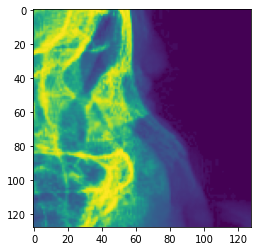

In [0]:
import matplotlib.pyplot as plt 
plt.imshow(normal_data[0].reshape((128,128)))

In [0]:
# 128,128,1 reshape
normal_data = np.expand_dims(normal_data, axis=-1)

# y_label create
normal_data_y = np.zeros((len(normal_data), 1)) # 비골절 0

print('normal shape',normal_data.shape, normal_data_y.shape)

# normal Data set maker
from sklearn.model_selection import train_test_split

X = np.array(normal_data)
Y = np.array(normal_data_y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
xy = (X_train, X_test, Y_train, Y_test)
np.save("normal_train_20.npy", xy)
np.save("/content/drive/My Drive/whole_train/1. whole_train/normal_train_20.npy", xy)

normal shape (8415, 128, 128, 1) (8415, 1)


### fracture

In [0]:
# /content/drive/My Drive/resize_reverse_crop_128/fracture_resize_reverse_crop
# 이미지 path
# normal_path = './x-ray/Normal_resize_reverse_crop/'
fracture_path = './fracture_resize_reverse_crop/'

# 이미지 증강 path
fracture_output_path ='/content/drive/My Drive/generator_images/fracture/'

if os.path.isdir(fracture_output_path) :
    print('yes. it is a folder')
else : 
    os.makedirs(fracture_output_path, exist_ok=True)
    print('create folder')

create folder


In [0]:
# 이미지 증강
generate_images_for_data_augmentation(fracture_path, fracture_output_path, '', 20)

error .DS_Store


In [0]:
# normal data set 
X_ = []

for file_name in tqdm(glob.glob(fracture_output_path + '*.jpg')):
    img = Image.open(file_name).convert('L')
    data = np.array(img)
    X_.append(data)

fracture_data = np.array(X_)
fracture_data = equalize_images(fracture_data) # 평활화
fracture_data = (fracture_data - 127.5) / 127.5
print(fracture_data.shape)

100%|██████████| 10405/10405 [00:18<00:00, 556.31it/s]


(10405, 128, 128)


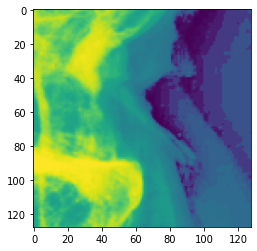

In [0]:
import matplotlib.pyplot as plt 
plt.imshow(fracture_data[0].reshape((128,128)))

In [0]:
# 128,128,1 reshape
fracture_data = np.expand_dims(fracture_data, axis=-1)

# y_label create
fracture_data_y = np.zeros((len(fracture_data), 1)) # 비골절 0

print('fracture shape', fracture_data.shape, fracture_data_y.shape)

# normal Data set maker
from sklearn.model_selection import train_test_split

X = np.array(fracture_data)
Y = np.array(fracture_data_y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
xy = (X_train, X_test, Y_train, Y_test)
np.save("fracture_train_20.npy", xy)
np.save("/content/drive/My Drive/whole_train/1. whole_train/fracture_train_20.npy", xy)

fracture shape (10405, 128, 128, 1) (10405, 1)


## Train

In [0]:
%cd /content/drive/My Drive/whole_train/1. whole_train

/content/drive/My Drive/whole_train/1. whole_train


In [0]:
import os
os.getcwd()

'/content/drive/My Drive/whole_train/1. whole_train'

In [0]:
import numpy as np 

# X_train , Y_train , X_test, Y_test = np.load('train.npy', allow_pickle=True)
_ , _ , X_test, Y_test = np.load('train.npy', allow_pickle=True)
X_train , Y_train , _, _ = np.load('normal_train_20.npy', allow_pickle=True)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(7573, 128, 128, 1)
(842, 128, 128, 1)
(1208, 128, 128, 1)
(1208, 1)


In [0]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization 
from keras.layers import concatenate, Conv2DTranspose, Reshape
from os import path

def whole_model():
    inputs = Input((128,128,1))
    depth = 16
    conv1 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.25)(pool2)

    conv3 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.25)(pool3)

    conv4 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.25)(pool4)

    conv5 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    pool5 = Dropout(0.25)(pool5)

    conv6 = Conv2D(int(depth*32), (3, 3), activation='relu', padding='same')(pool5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(int(depth*32), (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(int(depth*32), (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(int(depth*32), (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    pool6 = Dropout(0.25)(pool6)
    
    c_conv_output = pool6
    dense1 = Flatten()(c_conv_output)
    dense2 = Dense(int(depth*32), activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    c_outputs = Dense(2, activation='softmax')(dense2)
    c_model_ = Model(inputs=[inputs], outputs=[c_outputs] ,name= 'cn_model')


    up7 = concatenate([Conv2DTranspose(int(depth*32), (2, 2), strides=(2, 2), padding='same')(conv6), conv5], axis=3)
    conv7 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(int(depth*16), (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    
    up8 = concatenate([Conv2DTranspose(int(depth*16), (2, 2), strides=(2, 2), padding='same')(conv7), conv4], axis=3)
    conv8 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(int(depth*8), (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(int(depth*8), (2, 2), strides=(2, 2), padding='same')(conv8), conv3], axis=3)
    conv9 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(int(depth*4), (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    up10 = concatenate([Conv2DTranspose(int(depth*4), (2, 2), strides=(2, 2), padding='same')(conv9), conv2], axis=3)
    conv10 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(up10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(int(depth*2), (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10)    
    
    up11 = concatenate([Conv2DTranspose(int(depth*2), (2, 2), strides=(2, 2), padding='same')(conv10), conv1], axis=3)
    conv11 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(up11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Conv2D(int(depth*1), (3, 3), activation='relu', padding='same')(conv11)
    conv11 = BatchNormalization()(conv11)    
    
    conv12 = Conv2D(1, (1, 1), activation='tanh')(conv11)
    g_model = Model(inputs=[inputs], outputs=[conv12])

    return c_model_ , g_model

In [0]:
c_model_ , g_model = whole_model()

In [0]:
import keras 
c_model  = keras.models.load_model('eq_c_model.h5')
c_model.trainable = False
d_model  = keras.models.load_model('eq_gan_d.h5')
d_model.trainable = False
g_model.trainable = True

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
from IPython.display import clear_output
from keras.callbacks import Callback
import matplotlib.pyplot as plt

#callback util 

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):

        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.x_ = []
        self.accuracy = []
        self.val_accuracy = []
        

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.show()

        print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
        print("accuracy = ", self.accuracy[-1], ", val_accuracy = ", self.val_accuracy[-1])

    

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 학습 중에 loss 그리기
plot_losses = PlotLosses()

# overfitting이 발생하면 학습 중지
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# 학습 실행하면서 학습율 감소시키기
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


from keras import optimizers
from keras.optimizers import Adam
from os import path

callbacks = [plot_losses, reduce_lr]

In [0]:
# Util 함수

def show_result(target_data=X_test, count=10, threshold=0.2):

    shuffled_index = np.random.permutation(X_test.shape[0])
    shuffled_index = np.arange(0,count)
    model_input_shape = (1,128, 128, 1)

    for i in range(count):
        cl_ = Y_test[i]
        target_input = target_data[shuffled_index[i]]
        c_out = c_model.predict(target_input.reshape(model_input_shape)) 
        g_out = g_model.predict(target_input.reshape(model_input_shape))
        d_out = d_model.predict(g_out)
        c_out_g_in = c_model.predict(g_out)
        
        diff = np.absolute(g_out[0] - target_input)
        diff[diff < threshold] = 0.0

        # 실제 원본 이미지
        if Y_test[i] == 0 :
            print('Input is classified as Normal Image %.1f' % Y_test[i], '(0 : Normal, 1 : Fracture)')
        else : 
            print('Input is classified as Fracture Image %.1f' % Y_test[i], '(0 : Normal, 1 : Fracture)')

        # classify  0 normal, 1 fracture 원본이미지의 분류
        if c_out[0][1] <= 0.5 :  
            print('Classified as Normal Image %.3f' % c_out[0][1], '(0 : Normal, 1 : Fracture)')
        else :
            print('Classified as fractrue Image %.3f' % c_out[0][1], '(0 : Normal, 1 : Fracture)')
        
        # discriminator 0 real 1 fake 제너레이터를 통과한 이미지의 디스크리미네이터 진짜와 가짜
        d_out_ = np.argmax(d_out, axis = 1)
        if d_out_ <= 0.5 :  
            print('Generated is Discriminated as Real Image %.3f' % d_out_, '(0 : Real, 1 : Fake)')
        else : 
            print('Generated is Discriminated as Fake Image %.3f' % d_out_, '(0 : Real, 1 : Fake)')            
            
        # generator_classify 0 normal, 1 fracture 제너레이터의 분류
        if c_out_g_in[0][1] <= 0.5 :  
            print('Generated is classified as Normal Image %.3f' % c_out_g_in[0][1], '(0 : Normal, 1 : Fracture)')
        else :
            print('Generated is classified as Fracture Image %.3f' % c_out_g_in[0][1], '(0 : Normal, 1 : Fracture)')

            
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.title('Input img')
        plt.axis('off')
        plt.imshow(target_input.reshape((128,128)),cmap='gray' , vmin=0, vmax=1)
        
        plt.subplot(1,3,2)
        plt.title('Generated img')
        plt.axis('off')
        plt.imshow(g_out[0].reshape((128,128)),cmap='gray', vmin=0, vmax=1)
        
        plt.subplot(1,3,3)
        plt.title('Fracture area')
        plt.axis('off')
        plt.imshow(diff.reshape((128,128)),cmap='gray', vmin=0, vmax=1)
        plt.show()
        plt.close()
        print()
#cmap=plt.cm.binary
# show_result(X_test, threshold=0.1)

In [0]:
real = np.zeros(X_train.shape[0])
normal= np.zeros(X_train.shape[0])

## normal 0.002 0.997 0.001

In [0]:
inputs = Input((128,128,1))
generated = g_model(inputs)
d_output = d_model(generated)
c_output = c_model(generated)

# 비율로 최적화된 학습 
# d_r = 0.10 
# u_r = 0.80 
# c_r = 0.10 

# d_r = 0.05  0.06 0.07
# u_r = 0.90  0.88 0.86
# c_r = 0.05  0.06 0.07

d_r = 0.002
u_r = 0.997
c_r = 0.001

import keras.backend as K

def custom_loss(y_true, y_pred):
    return c_r * K.mean(c_output) + u_r * K.mean(keras.losses.mean_squared_error(inputs, generated)) + d_r * K.mean(d_output)

whole_model = Model(inputs=[inputs], outputs=[d_output, c_output])

whole_model.compile(loss=custom_loss, optimizer='adam', metrics=['accuracy'])
whole_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128, 128, 1)  17148161    input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            135041      model_1[1][0]                    
__________________________________________________________________________________________________
model_5 (Model)                 (None, 2)            12078674    model_1[1][0]                    
Total params: 29,361,876
Trainable params: 17,136,129
Non-trainable params: 12,225,747
_____

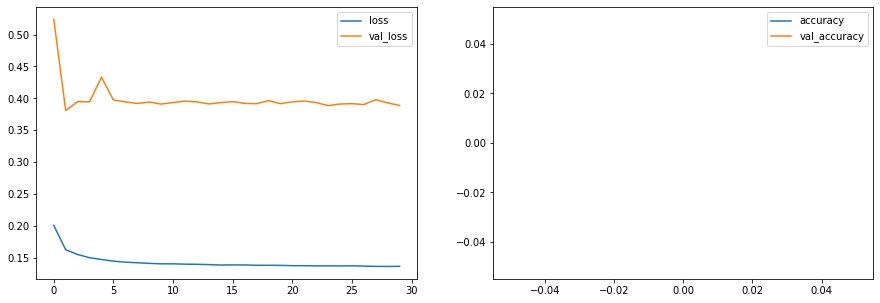

loss =  0.13671975809689926 , val_loss =  0.3888065994257663
accuracy =  None , val_accuracy =  None


In [0]:
hist = whole_model.fit(X_train, [real, normal], validation_split=0.1, epochs=30, batch_size=32, verbose=1, callbacks=callbacks, shuffle=True)

Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.999 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.998 (0 : Normal, 1 : Fracture)


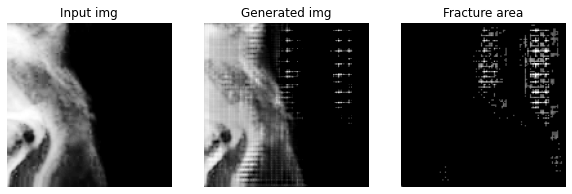


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.998 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


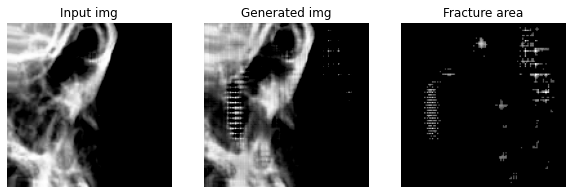


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.004 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


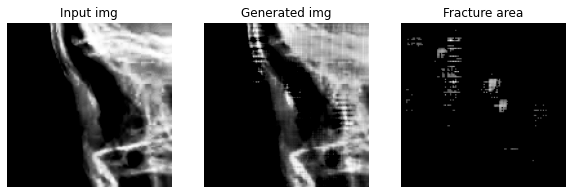


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


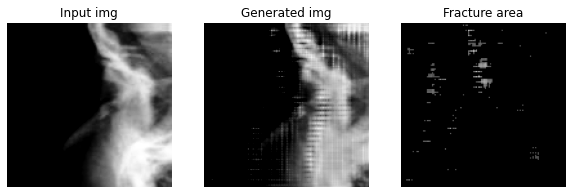


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.119 (0 : Normal, 1 : Fracture)


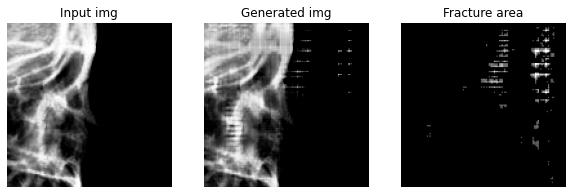


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


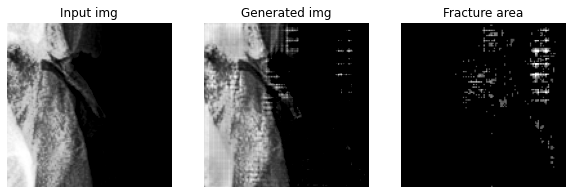


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.996 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


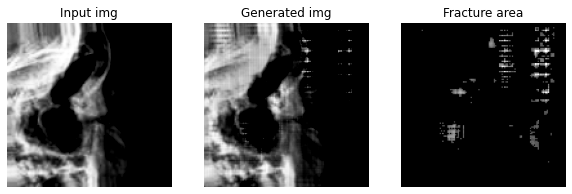


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.001 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.000 (0 : Normal, 1 : Fracture)


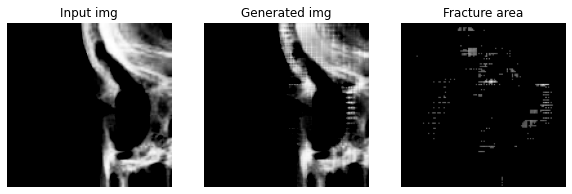


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.979 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.019 (0 : Normal, 1 : Fracture)


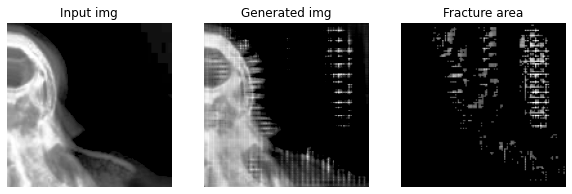


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.999 (0 : Normal, 1 : Fracture)


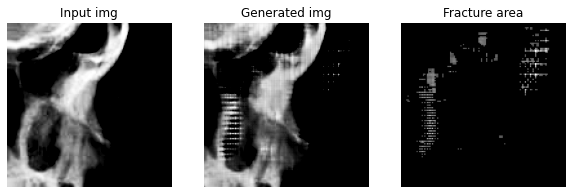

In [0]:
show_result(X_test,threshold = 0.3)

In [0]:
# 모델 저장
whole_model.save('./remodeled/eq_whole_0.002_0.997_colab.h5')

## normal 0.001 0.997 0.002

In [0]:
inputs = Input((128,128,1))
generated = g_model(inputs)
d_output = d_model(generated)
c_output = c_model(generated)

# 비율로 최적화된 학습 
# d_r = 0.10 
# u_r = 0.80 
# c_r = 0.10 

# d_r = 0.05  0.06 0.07
# u_r = 0.90  0.88 0.86
# c_r = 0.05  0.06 0.07

d_r = 0.001
u_r = 0.997
c_r = 0.002

import keras.backend as K

def custom_loss(y_true, y_pred):
    return c_r * K.mean(c_output) + u_r * K.mean(keras.losses.mean_squared_error(inputs, generated)) + d_r * K.mean(d_output)

whole_model = Model(inputs=[inputs], outputs=[d_output, c_output])

whole_model.compile(loss=custom_loss, optimizer='adam', metrics=['accuracy'])
whole_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128, 128, 1)  17148161    input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            135041      model_1[1][0]                    
__________________________________________________________________________________________________
model_5 (Model)                 (None, 2)            12078674    model_1[1][0]                    
Total params: 29,361,876
Trainable params: 17,136,129
Non-trainable params: 12,225,747
_____

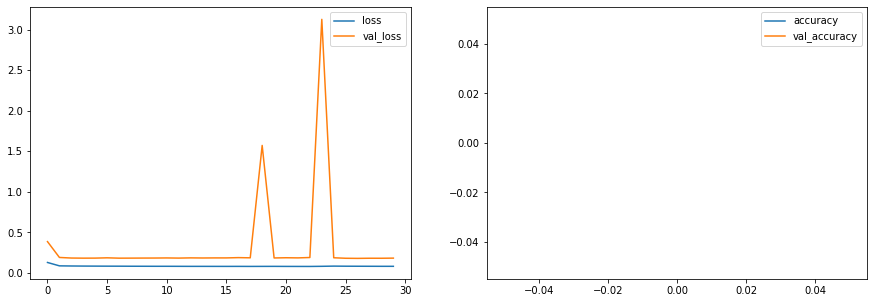

loss =  0.0824429017016753 , val_loss =  0.1833128837922632
accuracy =  None , val_accuracy =  None


In [0]:
hist = whole_model.fit(X_train, [real, normal], validation_split=0.1, epochs=30, batch_size=32, verbose=1, callbacks=callbacks, shuffle=True)

Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.999 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.998 (0 : Normal, 1 : Fracture)


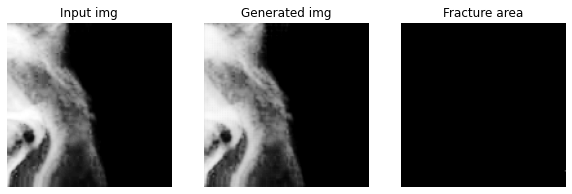


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.998 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.998 (0 : Normal, 1 : Fracture)


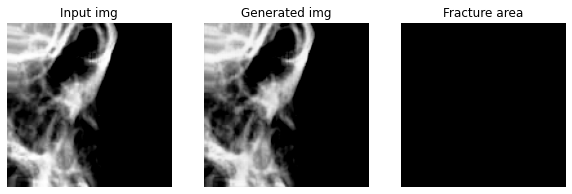


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.004 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.015 (0 : Normal, 1 : Fracture)


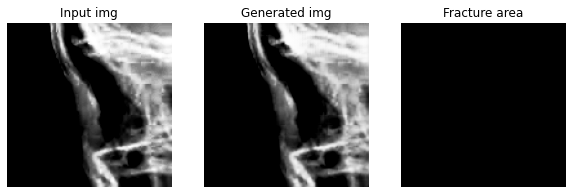


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


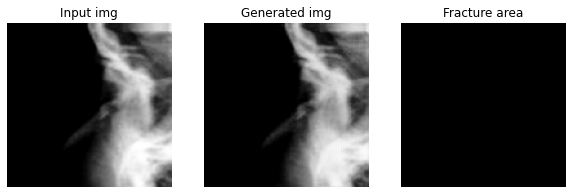


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.000 (0 : Normal, 1 : Fracture)


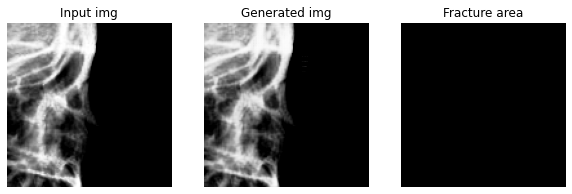


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


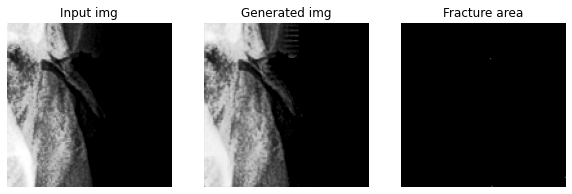


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.996 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.999 (0 : Normal, 1 : Fracture)


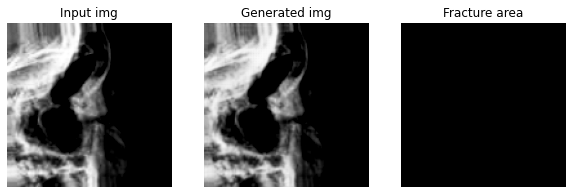


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.001 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.000 (0 : Normal, 1 : Fracture)


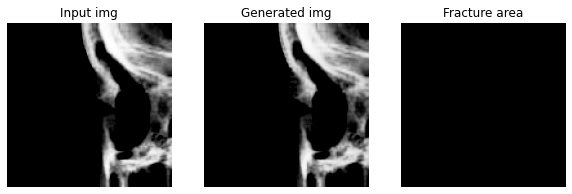


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.979 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.980 (0 : Normal, 1 : Fracture)


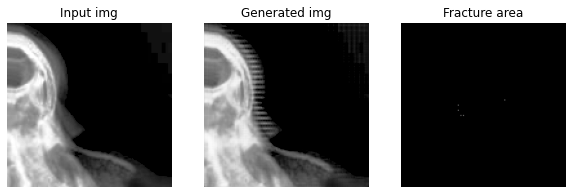


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.999 (0 : Normal, 1 : Fracture)


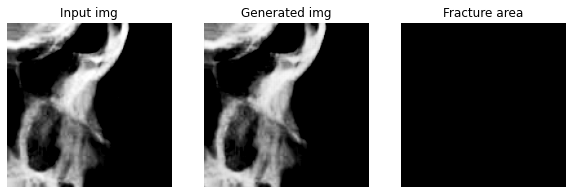

In [0]:
show_result(X_test,threshold = 0.3)

In [0]:
# 모델 저장
whole_model.save('./remodeled/eq_whole_0.001_0.997_colab.h5')

## normal 0.0015 0.997 0.0015

In [0]:
inputs = Input((128,128,1))
generated = g_model(inputs)
d_output = d_model(generated)
c_output = c_model(generated)

# 비율로 최적화된 학습 
# d_r = 0.10 
# u_r = 0.80 
# c_r = 0.10 

# d_r = 0.05  0.06 0.07
# u_r = 0.90  0.88 0.86
# c_r = 0.05  0.06 0.07

d_r = 0.0015
u_r = 0.997
c_r = 0.0015

import keras.backend as K

def custom_loss(y_true, y_pred):
    return c_r * K.mean(c_output) + u_r * K.mean(keras.losses.mean_squared_error(inputs, generated)) + d_r * K.mean(d_output)

whole_model = Model(inputs=[inputs], outputs=[d_output, c_output])

whole_model.compile(loss=custom_loss, optimizer='adam', metrics=['accuracy'])
whole_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128, 128, 1)  17148161    input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            135041      model_1[1][0]                    
__________________________________________________________________________________________________
model_5 (Model)                 (None, 2)            12078674    model_1[1][0]                    
Total params: 29,361,876
Trainable params: 17,136,129
Non-trainable params: 12,225,747
_____

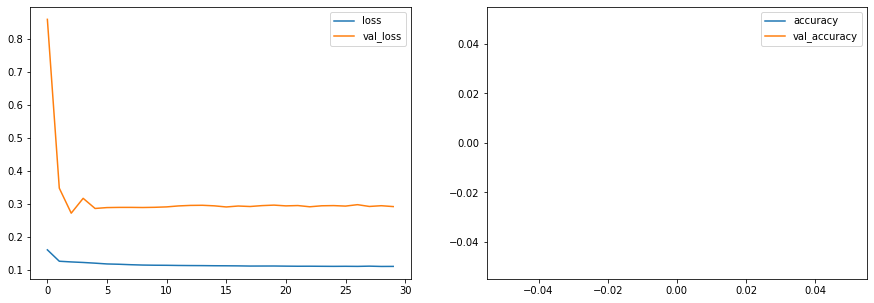

loss =  0.11082584617423032 , val_loss =  0.291874633300902
accuracy =  None , val_accuracy =  None


In [0]:
hist = whole_model.fit(X_train, [real, normal], validation_split=0.1, epochs=30, batch_size=32, verbose=1, callbacks=callbacks, shuffle=True)

Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.999 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


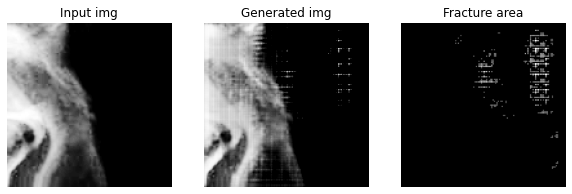


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.998 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


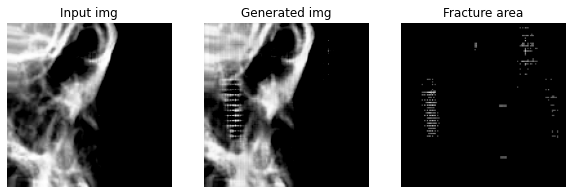


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.004 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.998 (0 : Normal, 1 : Fracture)


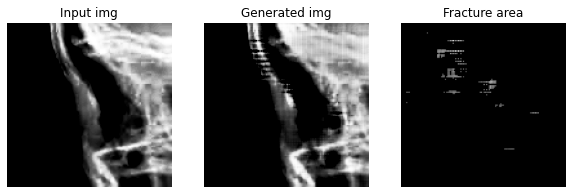


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.999 (0 : Normal, 1 : Fracture)


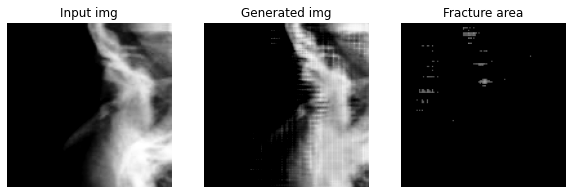


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.003 (0 : Normal, 1 : Fracture)


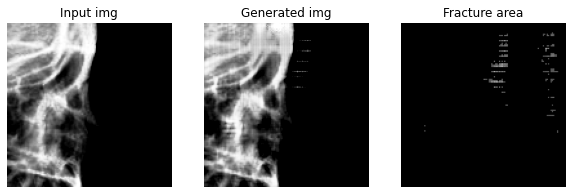


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.978 (0 : Normal, 1 : Fracture)


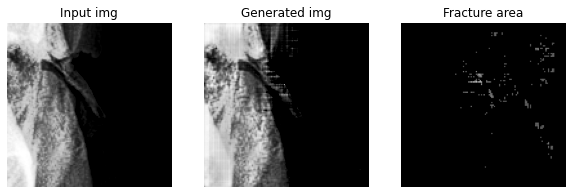


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.996 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.999 (0 : Normal, 1 : Fracture)


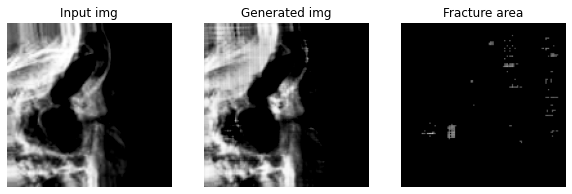


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.001 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.012 (0 : Normal, 1 : Fracture)


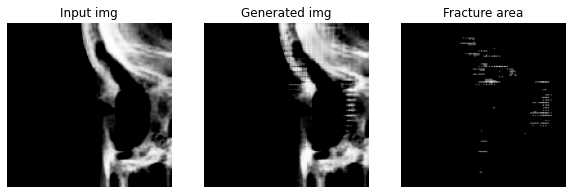


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.979 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.955 (0 : Normal, 1 : Fracture)


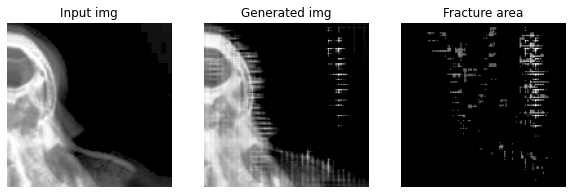


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.980 (0 : Normal, 1 : Fracture)


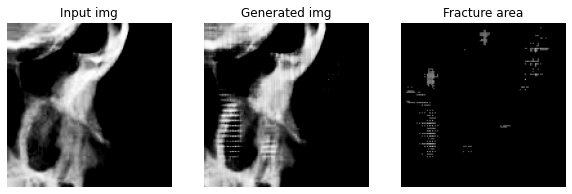

In [0]:
show_result(X_test,threshold = 0.3)

In [0]:
# 모델 저장
whole_model.save('./remodeled/eq_whole_0.0015_0.997_colab.h5')

## normal 0.0014 0.997 0.0016

In [0]:
inputs = Input((128,128,1))
generated = g_model(inputs)
d_output = d_model(generated)
c_output = c_model(generated)

# 비율로 최적화된 학습 
# d_r = 0.10 
# u_r = 0.80 
# c_r = 0.10 

# d_r = 0.05  0.06 0.07
# u_r = 0.90  0.88 0.86
# c_r = 0.05  0.06 0.07

d_r = 0.0014
u_r = 0.997
c_r = 0.0016

import keras.backend as K

def custom_loss(y_true, y_pred):
    return c_r * K.mean(c_output) + u_r * K.mean(keras.losses.mean_squared_error(inputs, generated)) + d_r * K.mean(d_output)

whole_model = Model(inputs=[inputs], outputs=[d_output, c_output])

whole_model.compile(loss=custom_loss, optimizer='adam', metrics=['accuracy'])
whole_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128, 128, 1)  17148161    input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            135041      model_1[1][0]                    
__________________________________________________________________________________________________
model_5 (Model)                 (None, 2)            12078674    model_1[1][0]                    
Total params: 29,361,876
Trainable params: 17,136,129
Non-trainable params: 12,225,747
_____

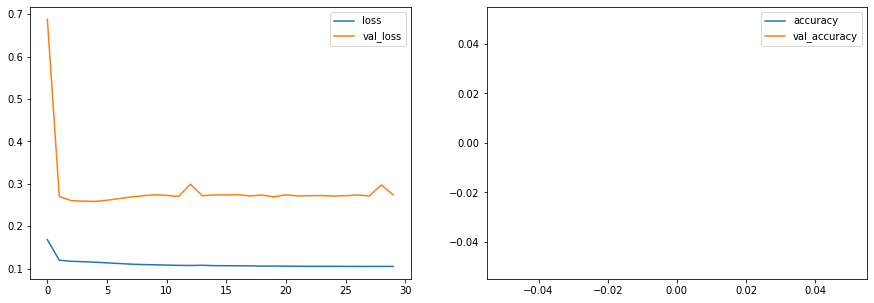

loss =  0.10536356339844727 , val_loss =  0.27387983770672436
accuracy =  None , val_accuracy =  None


In [0]:
hist = whole_model.fit(X_train, [real, normal], validation_split=0.1, epochs=30, batch_size=32, verbose=1, callbacks=callbacks, shuffle=True)

Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.999 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


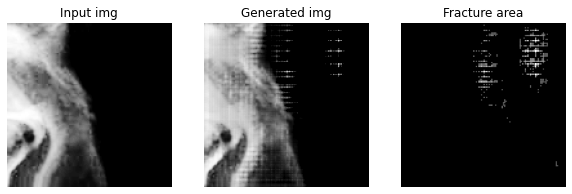


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.998 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


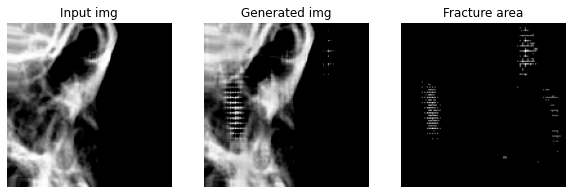


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.004 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.999 (0 : Normal, 1 : Fracture)


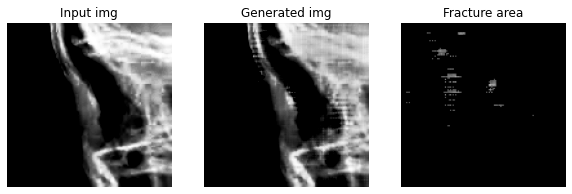


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


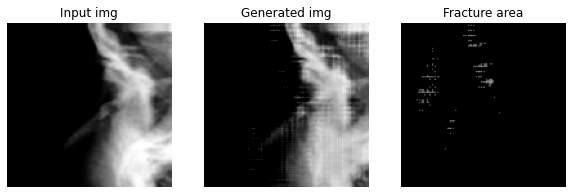


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.000 (0 : Normal, 1 : Fracture)


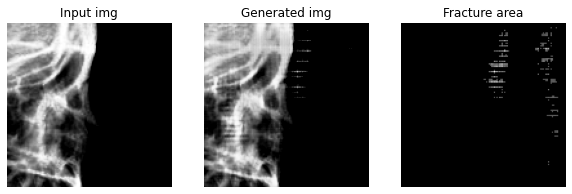


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


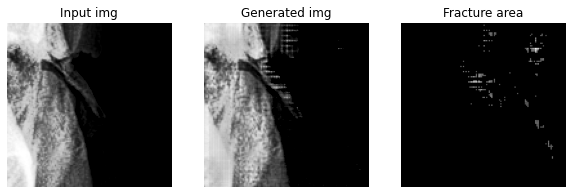


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.996 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.999 (0 : Normal, 1 : Fracture)


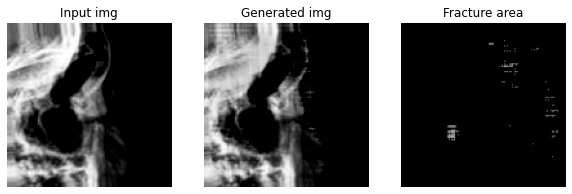


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.001 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.009 (0 : Normal, 1 : Fracture)


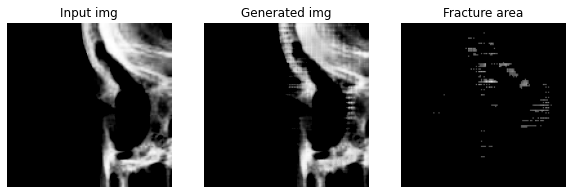


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.979 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.799 (0 : Normal, 1 : Fracture)


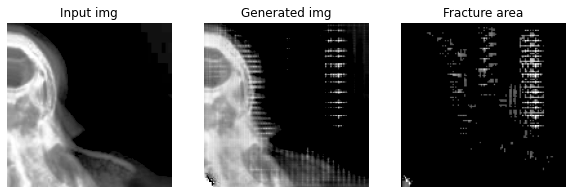


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.999 (0 : Normal, 1 : Fracture)


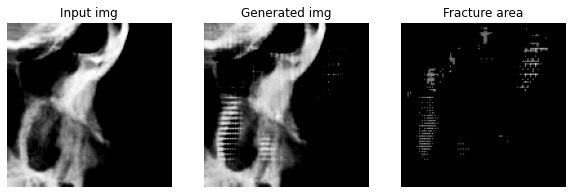

In [0]:
show_result(X_test,threshold = 0.3)

In [0]:
# 모델 저장
whole_model.save('./remodeled/eq_whole_0.0014_0.997_colab_normal.h5')

## fracture 0.0014 0.997 0.0016

In [0]:
X_train , Y_train , _, _ = np.load('fracture_train_20.npy', allow_pickle=True)

In [0]:
real = np.zeros(X_train.shape[0])
fracture= np.ones(X_train.shape[0])

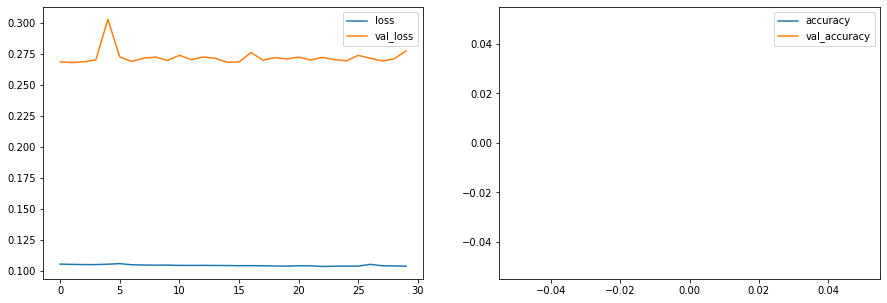

loss =  0.10397214910727853 , val_loss =  0.2774076386729579
accuracy =  None , val_accuracy =  None


In [0]:
hist = whole_model.fit(X_train, [real, fracture], validation_split=0.1, epochs=30, batch_size=32, verbose=1, callbacks=callbacks, shuffle=True)

Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.999 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.996 (0 : Normal, 1 : Fracture)


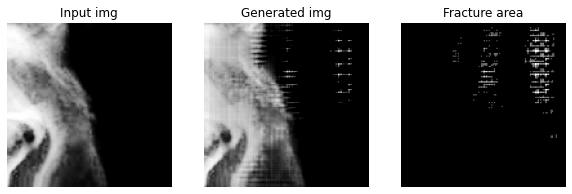


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.998 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


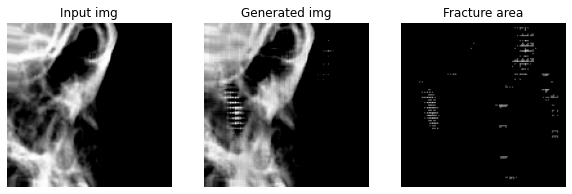


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.004 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.979 (0 : Normal, 1 : Fracture)


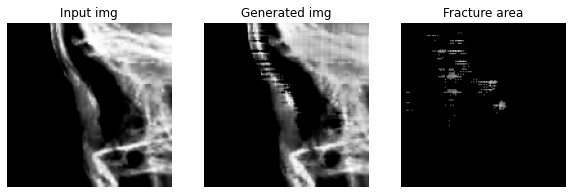


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


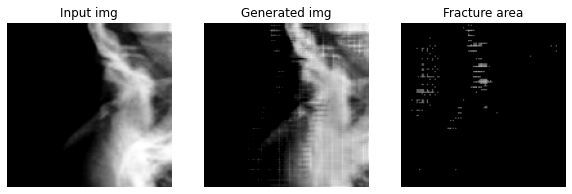


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.003 (0 : Normal, 1 : Fracture)


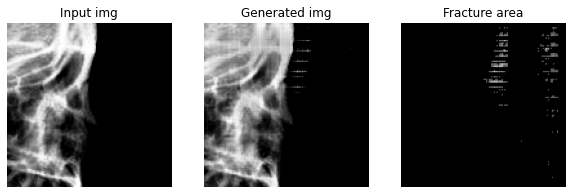


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 1.000 (0 : Normal, 1 : Fracture)


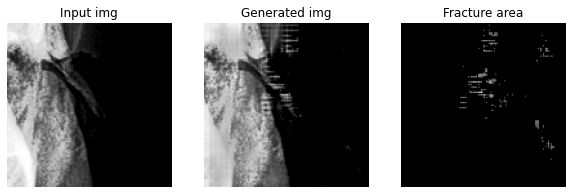


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.996 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.998 (0 : Normal, 1 : Fracture)


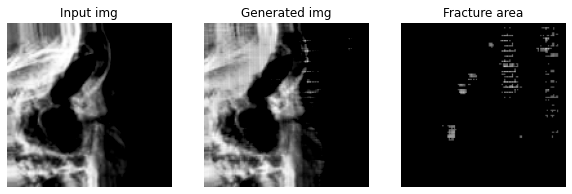


Input is classified as Normal Image 0.0 (0 : Normal, 1 : Fracture)
Classified as Normal Image 0.001 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.002 (0 : Normal, 1 : Fracture)


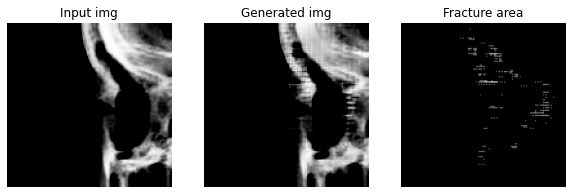


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 0.979 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Normal Image 0.050 (0 : Normal, 1 : Fracture)


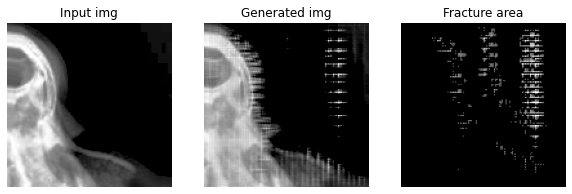


Input is classified as Fracture Image 1.0 (0 : Normal, 1 : Fracture)
Classified as fractrue Image 1.000 (0 : Normal, 1 : Fracture)
Generated is Discriminated as Real Image 0.000 (0 : Real, 1 : Fake)
Generated is classified as Fracture Image 0.999 (0 : Normal, 1 : Fracture)


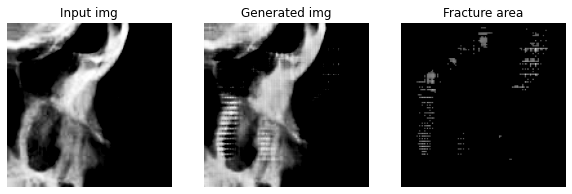

In [0]:
show_result(X_test,threshold = 0.3)

In [0]:
# 모델 저장
whole_model.save('./remodeled/eq_whole_0.0014_0.997_colab_normal_fracture.h5')